In [1]:
# Import some basic packages
%reset -f
import matplotlib.pyplot as plt
import numpy as np
import warnings
import os
#Josie's vis package
import FluvialVis as fv
import warnings
warnings.filterwarnings('ignore')

import matplotlib.colors as mcolors
colors = [(0,0.2,1,i) for i in np.linspace(0,1,3)]
mycmap = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=10)

# **Coupling Landlab components to simulate a floodplain response**
```
NetworkSedimentTransporter | OverlandFlow | SoilInfiltrationGreenAmpt
```

## Graphical abstract? 

<img src="https://i.imgur.com/jS8EqiI.jpg" alt="conceptual framework" width="500"/>

get_ipython().run_line_magic('matplotlib', 'inline')
warnings.filterwarnings('ignore')
import os
import shutil
import pathlib
from landlab.components import OverlandFlow, FlowAccumulator, SpatialPrecipitationDistribution, FlowDirectorSteepest, NetworkSedimentTransporter
from landlab.data_record import DataRecord
from landlab.components import SoilInfiltrationGreenAmpt
from landlab import RasterModelGrid
from landlab import ExampleData
from landlab.plot import plot_network_and_parcels

## 1. Drainage network topology

### 1.1 Import network from a shapefile

We start by loading a shapefile containing the topology of the drainage network as a Landlab grid which will be stored as `network_grid`. This network is composed of nodes and links, meaning it will work as a one-dimensional grid. 

In [2]:
# Package for reading shapefiles
from landlab.io import read_shapefile

# Read shapefile as Landlab grid
PATH_TO_SHAPEFILE = './data/hugo_links.shp'
network_grid = read_shapefile(PATH_TO_SHAPEFILE,threshold=0.1,)

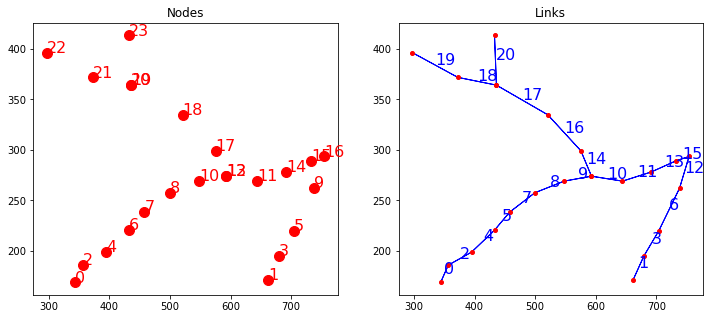

In [3]:
#plot network
fv.plot_network(network_grid)

### 1.2 Fix network and create a new one

Notice how `network_grid` is not *really* a network. For example, lines <font color='blue'>18</font> and <font color='blue'>20</font> should arrive to the same node, however, there are two nodes at the same location. After inspecting the plot, it seems that nodes <font color='red'>19</font> and <font color='blue'>13</font> can be deleted since nodes <font color='blue'>20</font> and <font color='blue'>12</font> are in the same place.

In [4]:
# Drop double nodes
drop_nodes = [19,13]
new_y_of_node =[]
new_x_of_node =[]

# Find the new x and y coordinates
for i, node in enumerate(network_grid.y_of_node):
    if i not in drop_nodes:
        new_y_of_node.append(node)

for i, node in enumerate(network_grid.x_of_node):
    if i not in drop_nodes:
        new_x_of_node.append(node)

The lines that arrived to those deleted points have to be rebuilt so they get to the nodes that we kept.

In [5]:
# Redirect all nodes
replace_nodes = [20,12]
nodes_reformatted=np.ravel(network_grid.nodes_at_link)

for node, replacement in zip(drop_nodes,replace_nodes):
    nodes_reformatted[np.where(nodes_reformatted==node)]=replacement

# Change index number     
for node in drop_nodes:
    nodes_reformatted[np.where(nodes_reformatted >node)] -=1
    
new_nodes_at_link=nodes_reformatted.reshape([21,2])

For this, a new grid is created, called `new_network_grid`.

In [6]:
# Package for building a new network
from landlab.grid.network import NetworkModelGrid 
new_network_grid = NetworkModelGrid((new_y_of_node, new_x_of_node), new_nodes_at_link)
#                                   ^                            ^ ^                ^
#                                   ^--------Node Coordinates----^ ^----Links id----^

Now the links in `new_network_grid` indeed form a network! 

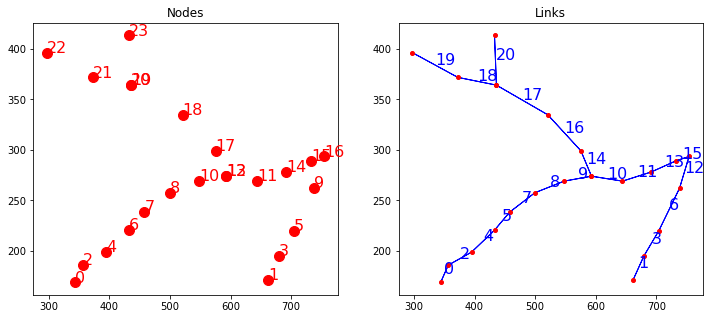

In [7]:
# Plot network topology
fv.plot_network(network_grid)

***
## 2. Rainfall and runoff on a topography

### 2.1 Import topography from a raster

Just as before, a raster file containing the topography of an area is loaded 
as a Landlab grid which will be stored as `rmg`. In this case, we will be dealing with a two-dimensional grid composed of the tiles that make up the raster file. 

The elevation attribute read from this raster is stored as `z`, which is connected to the fixed name `'topographic__elevation'`.

In [8]:
# Package for reading raster files
from landlab.io.esri_ascii import read_esri_ascii, write_esri_ascii

# Read raster as Landlab grid and assign info in raster as z.
PATH_TO_TOPOGRAPHY = './data/hugo_site.asc'
rmg, z = read_esri_ascii(PATH_TO_TOPOGRAPHY, name='topographic__elevation')

In [9]:
# Nodes with an elevation of -9999 are considered empty => interpreted as closed boundaries in the system
rmg.status_at_node[np.isclose(z, -9999.)] = rmg.BC_NODE_IS_CLOSED
rmg.set_watershed_boundary_condition('topographic__elevation')

Let's check the topography of this basin. Notice that we plot the `'topographic__elevation'` of the grid `rmg`, rather than plotting the `z` variable that we stored before. However, `z` points to `'topographic__elevation'`. 

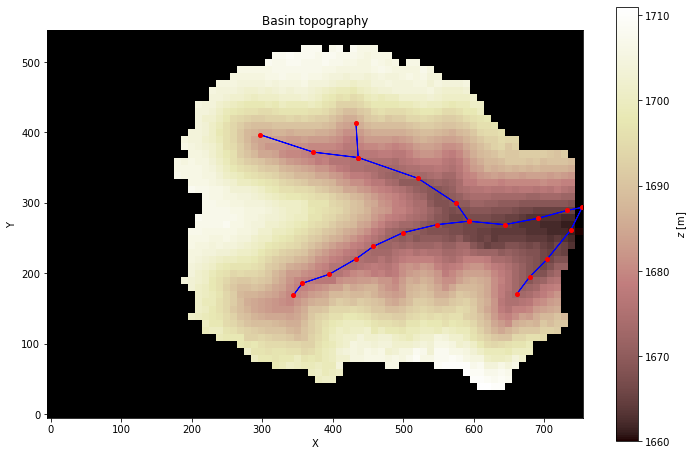

In [10]:
# Package for plotting raster data
fv.plot_topography(rmg,network_grid, new_network_grid)

### 2.2 Add a storm

Rain is added as a layer of water on top of the topography imported before. For the overland flow model, this is done by adding information to the `surface_water__depth` attribute of the grid `rmg` we are working on. 

First, we can add a homogeneous rain falling over the whole domain just by populating `surface_water__depth` with a constant value `h_init`.

In [11]:
# Initial thin layer of water (m)
h_init = 0.1 

# Start with a dry terrain
rmg.at_node["surface_water__depth"] = np.zeros(rmg.number_of_nodes)

h = rmg.at_node['surface_water__depth']  # h >> surface water depth
h += h_init                              #add a little bit of water everywhere

Similarly, a spatially variable rain pattern can be added modifying the array `h`. In this case, we add some more rain in a rectagular region. 

In [12]:
# Create a list of indexes where to add the rain
bools = (rmg.node_y > 100)*(rmg.node_y < 450)*(rmg.node_x < 400)*(rmg.node_x > 200)

# Add the rain only to the indexes defined above
h[bools] = 0.5 #initial water depth m

Let's check how this rain is distributed on the basin by plotting `h` with the `imshow_grid` function. 

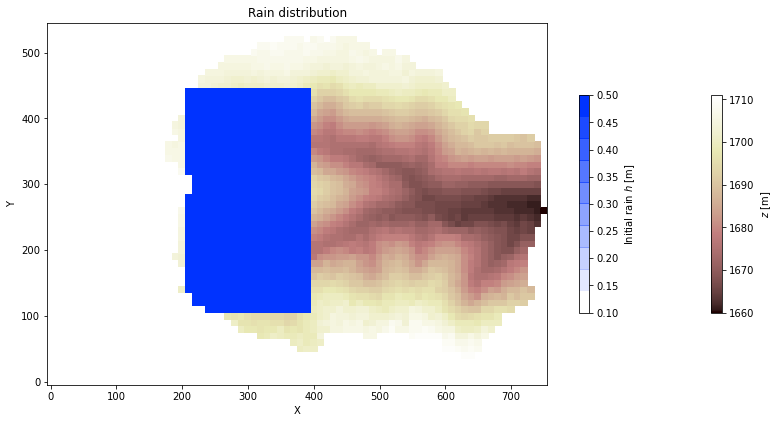

In [13]:
fv.plot_storm(rmg,mycmap, h)

### 2.3 Calculate the discharge

The rain field will act as the initial condition for the Overland Flow model to calculate the discharge in the basin. We start by initializing the `surface_water__discharge` attribute in `rmg`.

In [14]:
## Set inital discharge to zero
rmg.at_node["surface_water__discharge"] = np.zeros(rmg.number_of_nodes)

***
## 3. Sediment transport

****************************
I'm here :B

In [15]:
# Initial conditions
run_time =50000# 1 day 259200  # duration of run, (s) equivalent of 3 days
n = 0.01  # roughness coefficient, (s/m^(1/3))
g = 9.8  # gravity (m/s^2)
alpha = 0.7  # time-step factor (nondimensional; from Bates et al., 2010)
u = 0.4  # constant velocity (m/s, de Almeida et al., 2012)
elapsed_time = 1.0 #Elapsed time starts at 1 second. This prevents errors when setting our boundary conditions.

In [16]:
nmg_node_topo = np.zeros(new_network_grid.number_of_nodes) #create empty array holding elevations for network model grid
nmg_node_h = np.zeros(new_network_grid.number_of_nodes)

for i in range(new_network_grid.number_of_nodes):
    idx_nearest_raster_cell = rmg.find_nearest_node([new_network_grid.x_of_node[i], new_network_grid.y_of_node[i]])
    nmg_node_topo[i] = rmg.at_node["topographic__elevation"][idx_nearest_raster_cell]

nmg_link_length = np.zeros(new_network_grid.number_of_links)
nmg_link_h = np.zeros(new_network_grid.number_of_links)

In [17]:
for i in range(new_network_grid.number_of_links):
    idx_node_1_link = new_network_grid.nodes_at_link[i][0]
    idx_node_2_link = new_network_grid.nodes_at_link[i][1]
    nmg_link_length[i] = np.sqrt((new_network_grid.x_of_node[idx_node_2_link] - new_network_grid.x_of_node[idx_node_1_link])**2 
                         + (new_network_grid.y_of_node[idx_node_2_link] - new_network_grid.y_of_node[idx_node_1_link])**2)
    square_idx = rmg.find_nearest_node([new_network_grid.x_of_node[idx_node_1_link], new_network_grid.y_of_node[idx_node_1_link]]) #get raster grid idx closest to link tail
    nmg_link_h[i] = rmg.at_node['surface_water__depth'][square_idx] #assign surface at square_idx to network grid

new_network_grid.at_node["topographic__elevation"] = nmg_node_topo.copy()

new_network_grid.at_node["bedrock__elevation"] = nmg_node_topo.copy()

new_network_grid.at_link["channel_width"] = 10 * np.ones(new_network_grid.number_of_links)

new_network_grid.at_link["flow_depth"] = nmg_link_h.copy()

new_network_grid.at_link["reach_length"] = nmg_link_length

In [18]:
from landlab.components import SpatialPrecipitationDistribution
import shutil
# Folder for rainfall data
dir_rainfall = './rainfall_series'
# Overwrite or create directory for rainfall data
if os.path.exists(dir_rainfall):
    shutil.rmtree(dir_rainfall)
os.makedirs(dir_rainfall)

# time scale for rainfall events. To be adjusted. I am cheating with units... 
nb_years = 100
# Factor to scale rainfall values from the module SpatialPrecipitationDistribution (may generate very
# small amounts of rainfall, which renders poorly...)
rainfall_scaling = 10.

# Create time series of rainfall events (output is in mm/h)
rain = SpatialPrecipitationDistribution(rmg,number_of_years = nb_years)
np.random.seed(26)  # arbitrary to get a cool-looking storm out every tim

# Container for rainfall duration
storm_t_all = []
interstorm_t_all = []

# get the storm simulator to provide a storm
# Variables required to generate rainfall datasets
i = 0
max_rainfall = []
for (storm_t, interstorm_t) in rain.yield_storms():  # storm lengths in hrs
    i += 1
    rmg.at_node['rainfall__flux'] *= 0.001  # because the rainfall comes out in mm/h
    rmg.at_node['rainfall__flux'] *= rainfall_scaling  # to make the storm heavier and more interesting!

    # Save rainfall data to ascii file
    write_esri_ascii('./'+ dir_rainfall +'/rainfall_'+ str(i) + '.asc', rmg, 'rainfall__flux', clobber=True)
    
    # Save duration of storm and non-storm periods
    storm_t_all.append(storm_t)
    interstorm_t_all.append(interstorm_t)
    
    # Store max rainfall value
    max_rainfall.append(max(rmg.at_node['rainfall__flux']))

storm_ids = np.array(range(len(storm_t_all))) + 1

# Get moment of storms (initially in hours, to be rescaled over run_time 
# -> cheating to get some results...)
days_storms = (np.array(interstorm_t_all)/24)
scaled_days_storms_steps = (days_storms * (run_time / (nb_years*365))).round()
scaled_days_storms = scaled_days_storms_steps.cumsum()
# Set first storm a time = 1
scaled_days_storms = scaled_days_storms - scaled_days_storms[0] + 1

#Set initial water depth values and rainfall flux values
rmg.at_node["surface_water__depth"] = np.zeros(rmg.number_of_nodes)
rmg.at_node.pop('rainfall__flux')
# print(rmg.at_node.keys())

# Read first rainfall data
q_rain = read_esri_ascii(dir_rainfall + '/rainfall_1.asc', grid=rmg, name='rainfall__flux')
# Update id for rainfall
rainfall_id = 1

# Update surface water depth with rainfall data
rmg.at_node['surface_water__depth'].fill(1.e-12)  # a veneer of water stabilises the model
rmg.at_node['surface_water__depth'] += rmg.at_node['rainfall__flux'] # storm_t_all[0]

## Set inital discharge
rmg.at_node["surface_water__discharge"] = np.zeros(rmg.number_of_nodes)



In [19]:
# element_id is the link on which the parcel begins. 
element_id = np.repeat(np.arange(new_network_grid.number_of_links), 50)
element_id = np.expand_dims(element_id, axis=1)

volume = 1*np.ones(np.shape(element_id))  # (m3)
active_layer = np.ones(np.shape(element_id)) # 1= active, 0 = inactive
density = 2650 * np.ones(np.size(element_id))  # (kg/m3)
abrasion_rate = 0 * np.ones(np.size(element_id)) # (mass loss /m)

# Lognormal GSD
medianD = 0.004 # m
mu = np.log(medianD)
sigma = np.log(2) #assume that D84 = sigma*D50
np.random.seed(42)
D = np.random.lognormal(
    mu,
    sigma,
    np.shape(element_id)
)  # (m) the diameter of grains in each parcel

time_arrival_in_link = np.random.rand(np.size(element_id), 1) 
location_in_link = np.random.rand(np.size(element_id), 1) 

In [20]:
from landlab.data_record import DataRecord
from landlab.components import NetworkSedimentTransporter, OverlandFlow
from landlab import RasterModelGrid

lithology = ["quartzite"] * np.size(element_id)

variables = {
    "abrasion_rate": (["item_id"], abrasion_rate),
    "density": (["item_id"], density),
    "lithology": (["item_id"], lithology),
    "time_arrival_in_link": (["item_id", "time"], time_arrival_in_link),
    "active_layer": (["item_id", "time"], active_layer),
    "location_in_link": (["item_id", "time"], location_in_link),
    "D": (["item_id", "time"], D),
    "volume": (["item_id", "time"], volume)
}


items = {"grid_element": "link", "element_id": element_id}

parcels = DataRecord(
    new_network_grid,
    items=items,
    time=[0.0],
    data_vars=variables,
    dummy_elements={"link": [NetworkSedimentTransporter.OUT_OF_NETWORK]},
)

dt_sed = 50 # 60 * 60 * 24 *1# length of timestep (seconds) 


In [21]:
# set up overland flow grid for small-scale floodplain
Channel_Depth = 2
Channel_Width = 10
nX = 200
nY = 100
spacing = 1.0
Datum = 1665.0 + Channel_Depth
h_initFP = 0.1


def makeFP(Channel_Depth, Channel_Width = 10):
   
    #Define grid
    nX = 200
    nY = 100
    spacing = 1.0
    Datum = 1665.0 + Channel_Depth
    h_initFP = 0.1

    _grd = RasterModelGrid((nX, nY), xy_spacing=1.)

    # Pointer to topographic elevation > z
    _z = np.ones(nX*nY) * Datum
    _z = _grd.add_field('topographic__elevation', _z, at='node')

    
    # Add a longitudinal slope 
    ## (makes thing flow north to south)
    Long_Slope = 1./1000
    _z += _grd.node_y*Long_Slope

    # Add the channel indentation 
    ## (it's just a straigth strip)
    
    isChannel = (_grd.node_x > (nY/2 - Channel_Width/2)) * (_grd.node_x < (nY/2 + Channel_Width/2))
    _z[isChannel] -= Channel_Depth

    # Add a slope to the banks
    ## (so water flows always towards the main channel)
    Transversal_Slope = 1./100
    _z += np.abs(_grd.node_x-(nY/2))*Transversal_Slope

    # Add some random noise to the floodplains
    ## (makes the hillshading look prettier)
    _z += ~isChannel * np.reshape(np.tile(np.random.rand(10,10)*0.20,[int(nX/10),int(nY/10)]),nX*nY) 
    
    return _grd, _z, isChannel


In [22]:
gridFP, zFP, isChannel = makeFP(Channel_Depth = 2)

In [23]:
# Pointer to surface water depth in the 2D floodplain
hFP = np.zeros(nX*nY)
bools = (gridFP.node_x > nY/2 - Channel_Width*3) * (gridFP.node_x < nY/2 + Channel_Width*2) * (gridFP.node_y >= nX-5)
hFP[bools] = Channel_Depth*0.5
hFP += h_initFP
hFP = gridFP.add_field('surface_water__depth', hFP, at='node')

#####################################
# Spatially variable hydraulic cond. 
#####################################

dFP = gridFP.add_ones("soil_water_infiltration__depth", at="node", dtype=float)
dFP *= 0.2
#open boundaries 
gridFP.set_fixed_value_boundaries_at_grid_edges(True, True, False, True,value=0, value_of = 'surface_water__depth')
hcFP = gridFP.add_ones('hydraulic_conductivity', at='node')
hcFP *= 1.0E-5

infBandWidthNorm = 0.3
infBandWidth = nY/2 * infBandWidthNorm

channel_left = (nY + Channel_Width) / 2
channel_right = (nY - Channel_Width) / 2

#Define high infiltration bands at the banks

highInfBand = np.logical_and(gridFP.x_of_node < channel_left + infBandWidth, 
                             gridFP.x_of_node > channel_right - infBandWidth)
inf_maskFP = np.logical_xor(highInfBand, isChannel)

hcFP[inf_maskFP] *= 10

In [24]:
# Initialize model components
from landlab.components import SoilInfiltrationGreenAmpt, FlowDirectorSteepest
# overland flow in the floodplain
floodplainOF = OverlandFlow(gridFP, steep_slopes=True)

# soil infiltration in the floodplain
SI = SoilInfiltrationGreenAmpt(gridFP, hydraulic_conductivity=hcFP)

# Flow direction in channel network
fd = FlowDirectorSteepest(new_network_grid, "topographic__elevation")
fd.run_one_step()

#network sed transporter 
nst = NetworkSedimentTransporter(    
    new_network_grid,
    parcels,
    fd,
    bed_porosity=0.3,
    g=9.81,
    fluid_density=1000,
    transport_method="WilcockCrowe",
)
from landlab.plot import graph, plot_network_and_parcels

networkOF = OverlandFlow(rmg, steep_slopes=True)
networkOF.run_one_step()


In [25]:
# look at hydrograph at outlet 
hydrograph_time = []
discharge_at_outlet = []
height_at_outlet = []

#Define the outlet 
outlet_nearest_raster_cell = rmg.find_nearest_node([new_network_grid.x_of_node[14], new_network_grid.y_of_node[14]]) 
# did not choose 15 since at boundary
outlet_link_to_sample = rmg.links_at_node[outlet_nearest_raster_cell][3]

#define group of cells to search for high water level 
search_box = rmg.nodes_around_point(new_network_grid.x_of_node[14], new_network_grid.y_of_node[14]) 

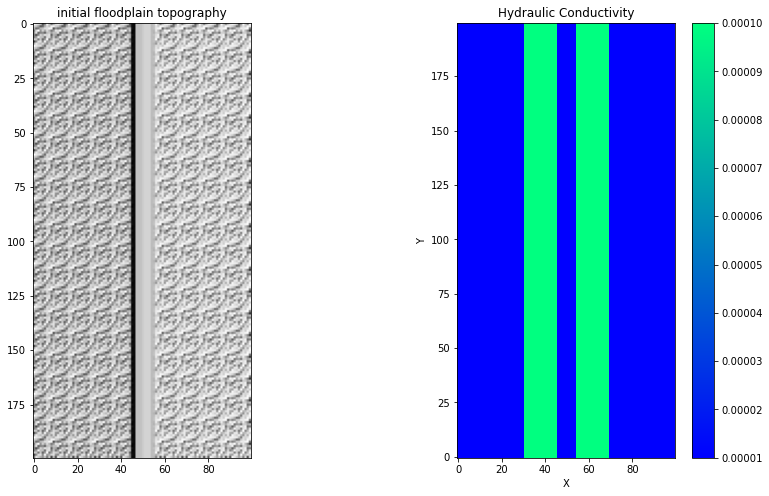

In [26]:
# Plot floodplain
fv.plot_initial_floodplain(zFP, nX, nY, gridFP)
# Folders fro saving figures
dir_output_list = ['./output/floodplain', './output/flow','./output/sed']
for folder in dir_output_list:
# Overwrite or create directory for plots
    if os.path.exists(folder):
        shutil.rmtree(folder)
    os.makedirs(folder)
    

50


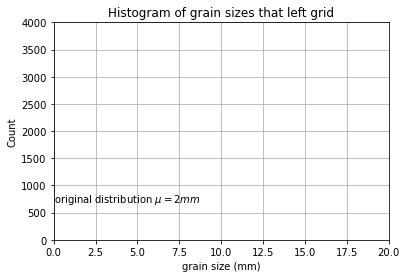

56.113717682
100


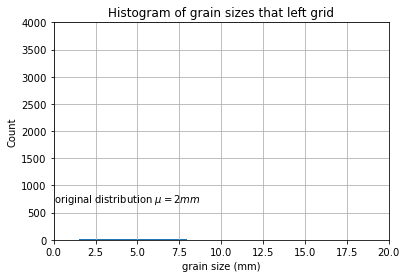

104.569772456
150


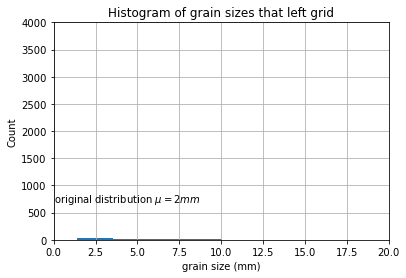

153.462137464
200


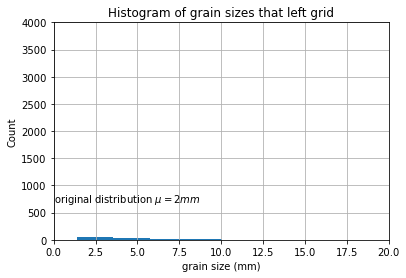

203.085656765
250


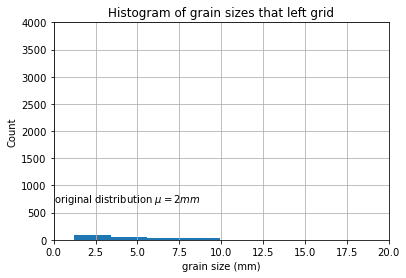

252.35791705
300


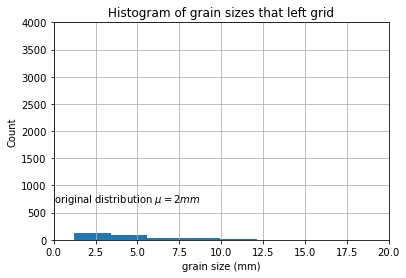

302.304097616
350


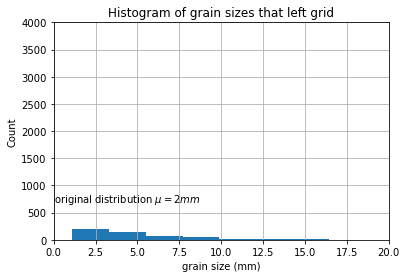

351.696696378
400


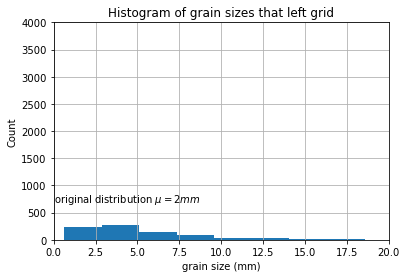

401.562753577
450


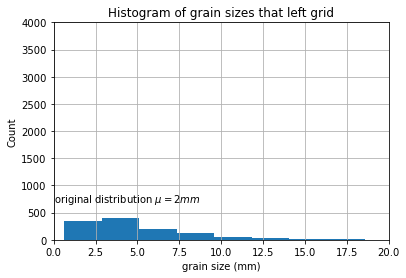

451.358379221
500


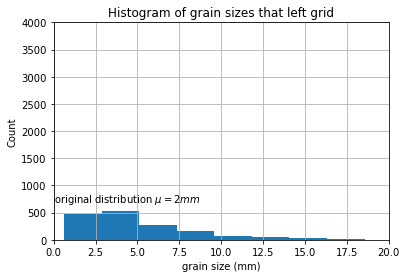

501.694957817
550


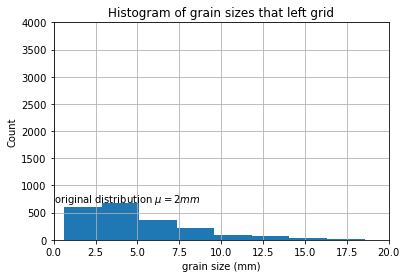

551.691527878
600


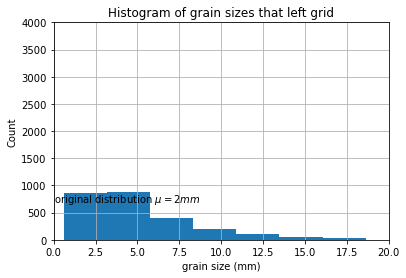

601.857780605
650


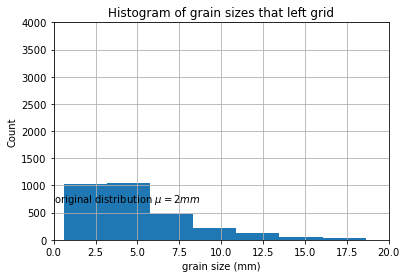

652.158719915
700


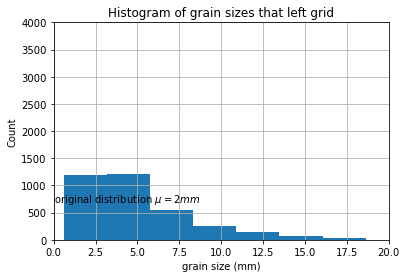

702.01634292
750


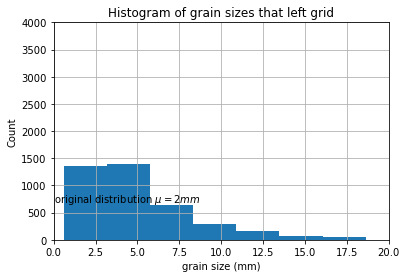

751.911863448
800


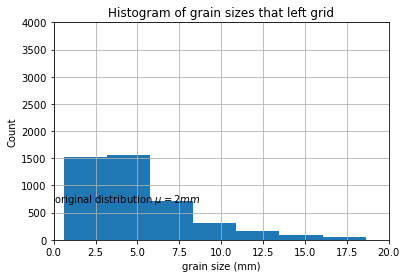

802.342902261
850


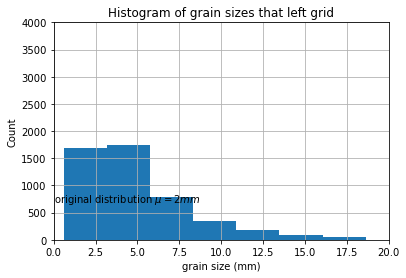

852.305609957
900


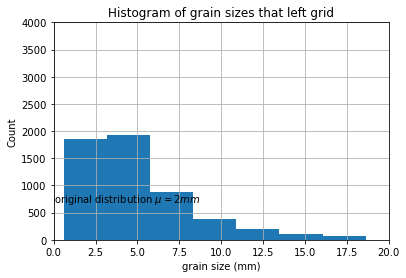

902.247802083
950


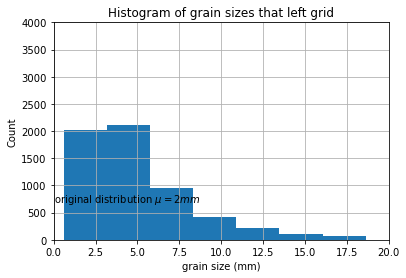

952.021493965
1000


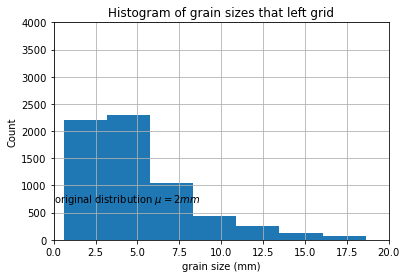

1001.78487059
1050


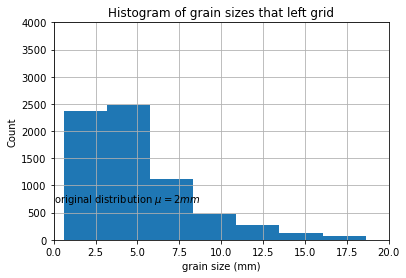

1051.9900543
1100


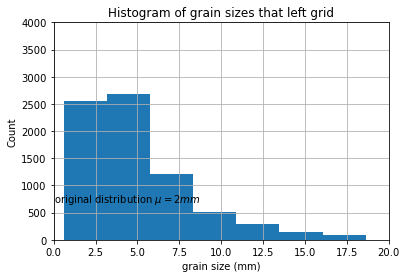

1102.17197178
1150


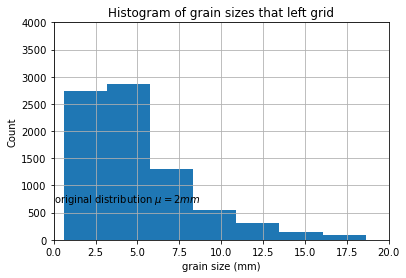

1151.86430465
1200


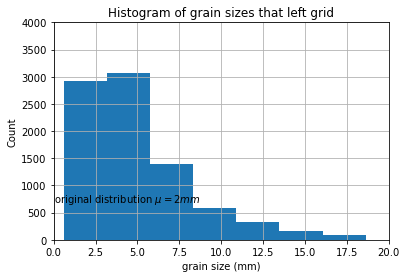

1202.1088249
1250


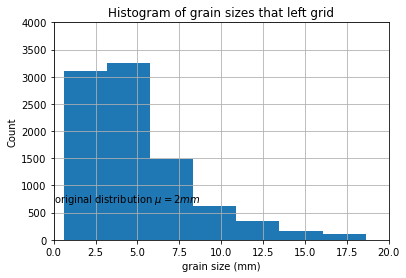

1251.91921421
1300


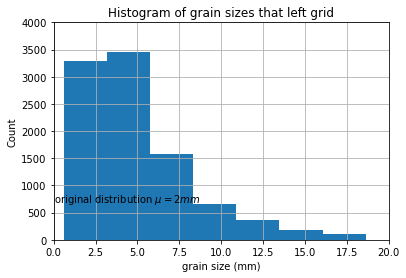

1302.13116462
1350


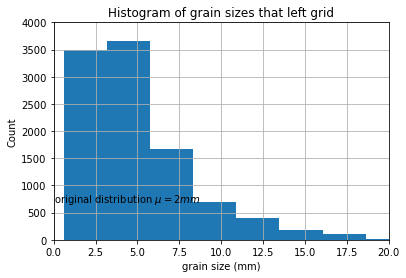

1351.61818998
1400


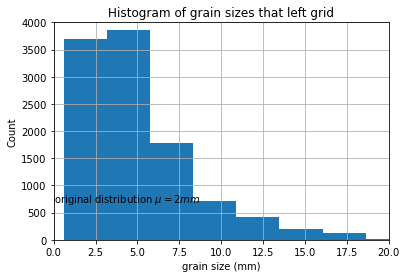

1401.52719538
1450


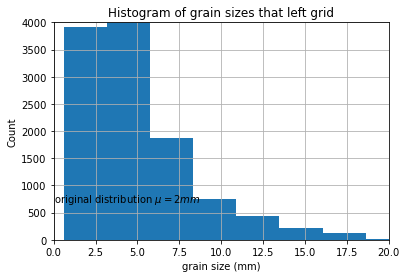

1451.40314357
1500


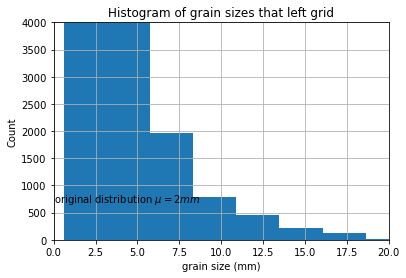

1501.82067218
1550


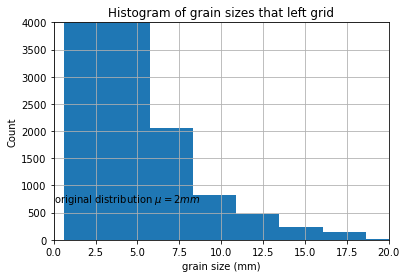

1551.88591408
1600


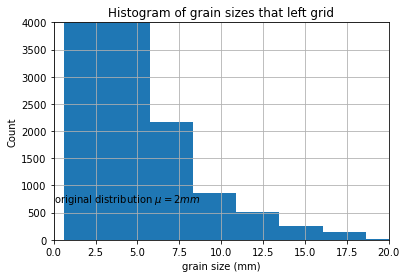

1602.11125784
1650


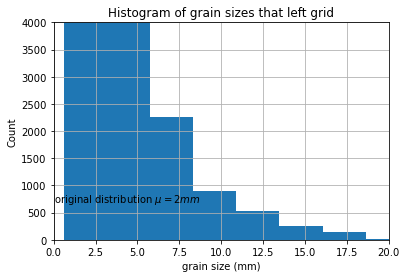

1651.96909219
1700


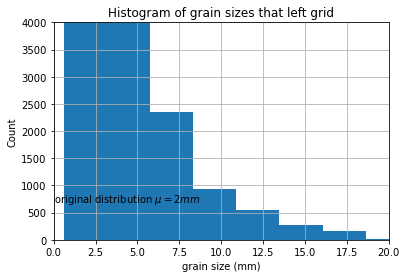

1702.4015221
1750


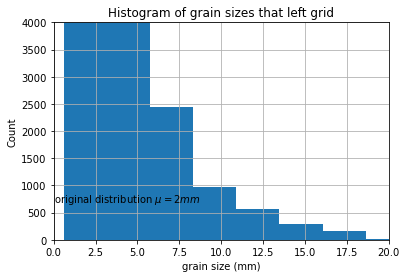

1752.36794285
1800


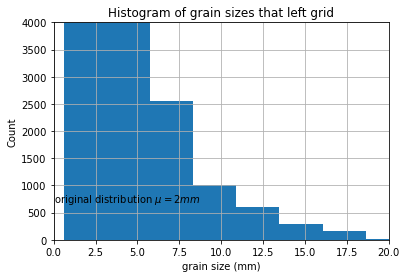

1802.31156343
1850


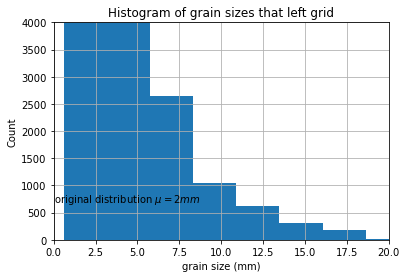

1852.15931572
1900


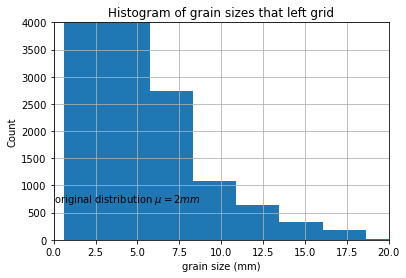

1901.94580076
1950


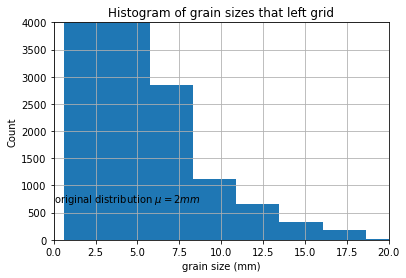

1952.19952546
2000


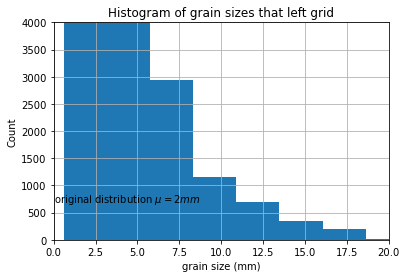

2001.981458
2050


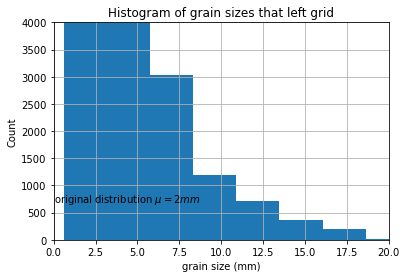

2052.31941592
2100


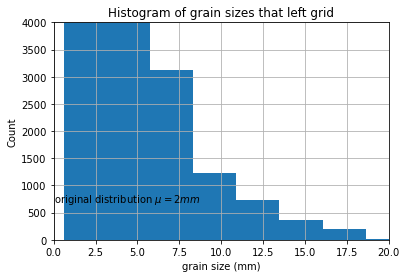

2102.20849363
2150


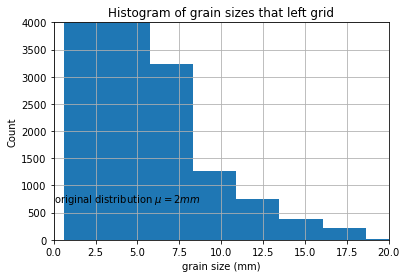

2152.1394045
2200


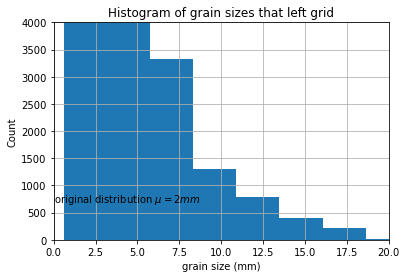

2202.10463016
2250


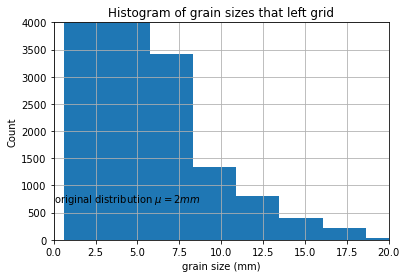

2252.07636829
2300


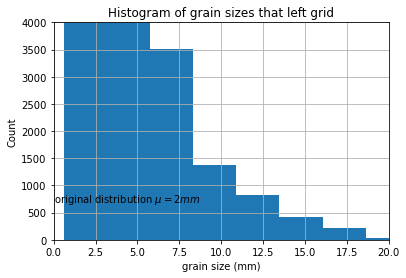

2301.28561122
2350


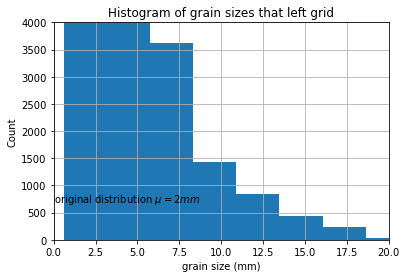

2351.10496078
2400


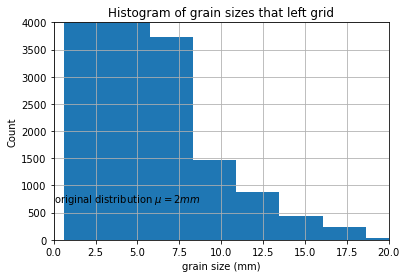

2400.7999432
2450


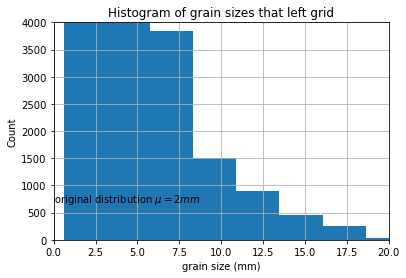

2451.04105424
2500


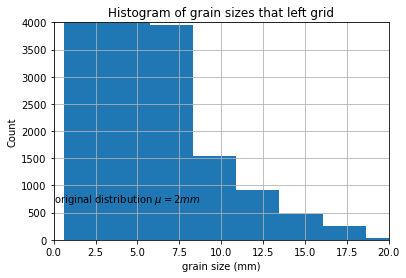

2500.81395739
2550


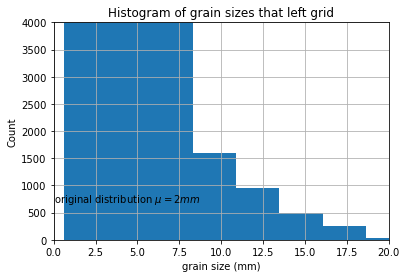

2550.99445026
2600


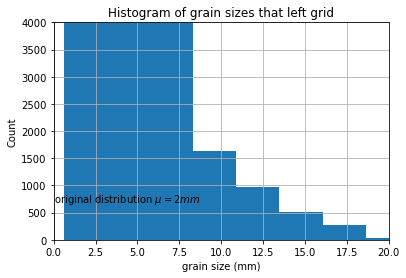

2601.12664932
2650


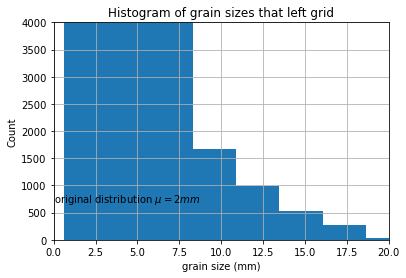

2650.79406196
2700


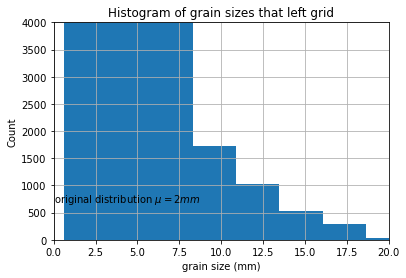

2700.98077999
2750


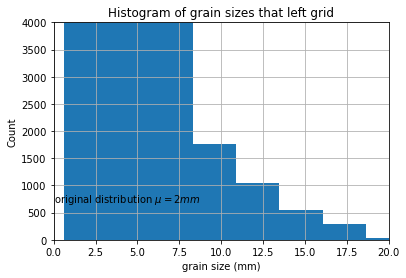

2751.20259372
2800


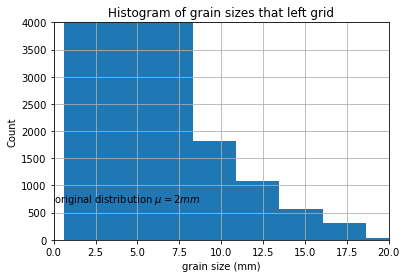

2800.96168848
2850


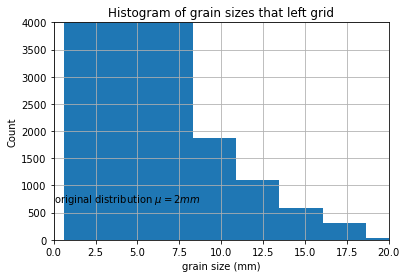

2851.23374997
2900


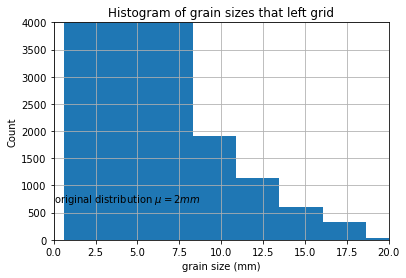

2901.00824015
2950


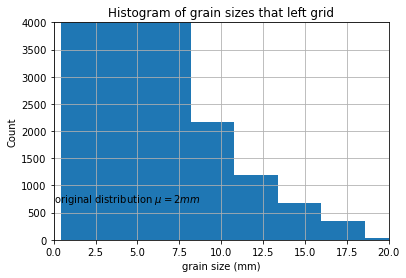

2950.82009546
3000


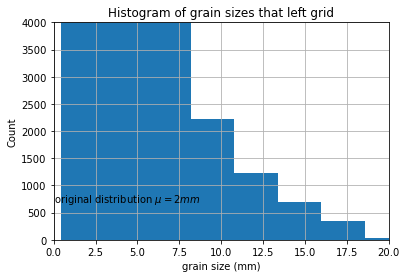

3001.18719629
3050


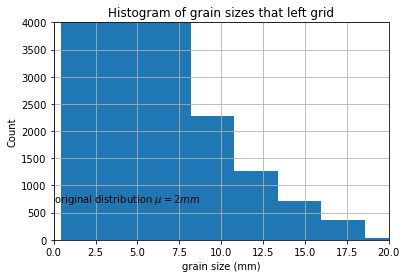

3051.13660629
3100


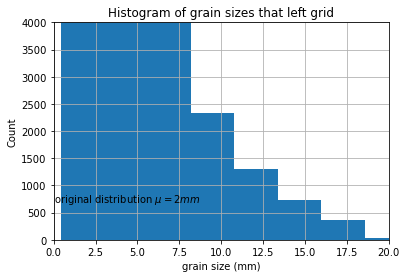

3101.21255329
3150


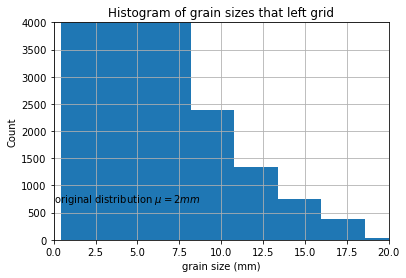

3151.56674292
3200


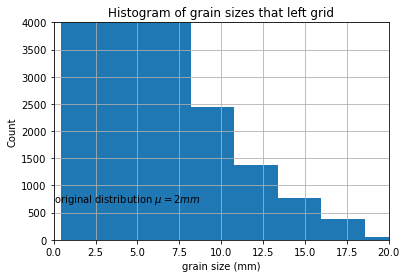

3201.6435804
3250


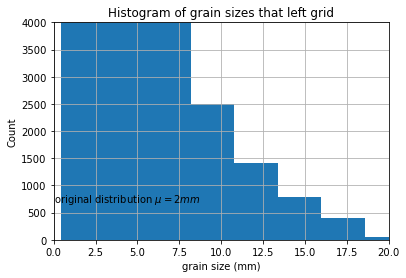

3251.7207981
3300


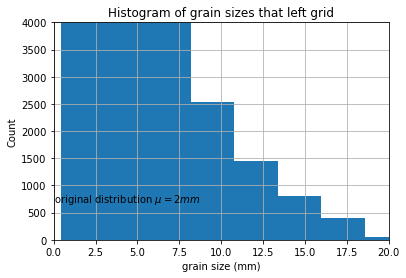

3301.76377052
3350


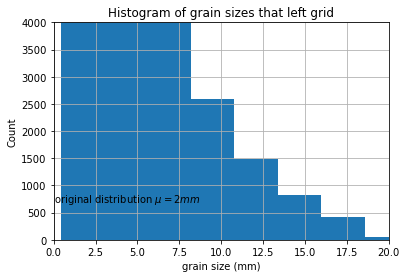

3351.82752976
3400


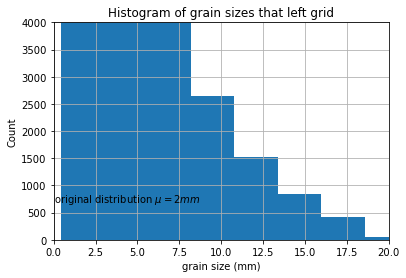

3401.8424258
3450


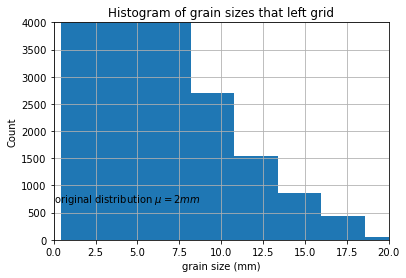

3451.90301229
3500


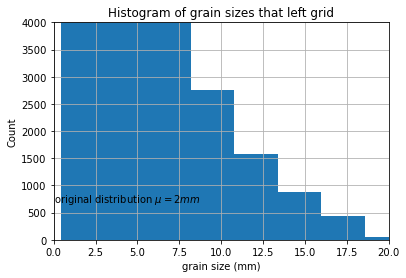

3501.91602364
3550


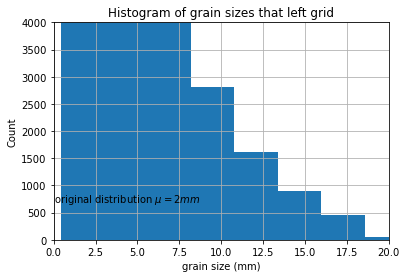

3551.99127726
3600


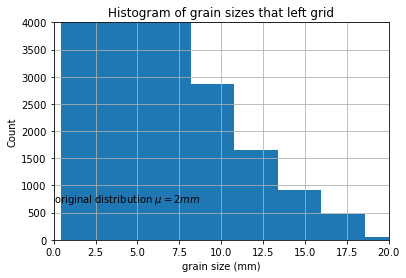

3602.06728218
3650


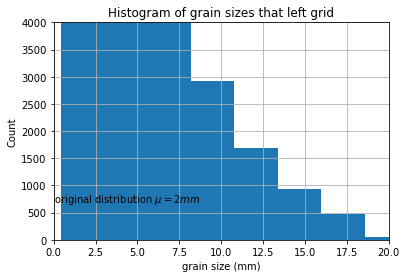

3651.64384363
3700


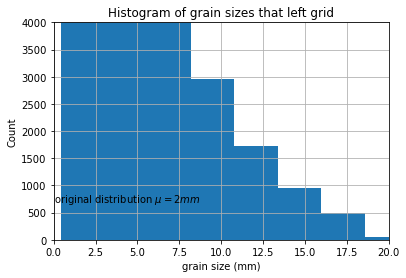

3701.72084205
3750


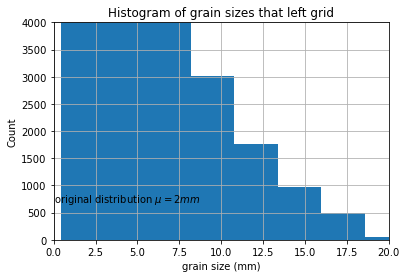

3751.79818993
3800


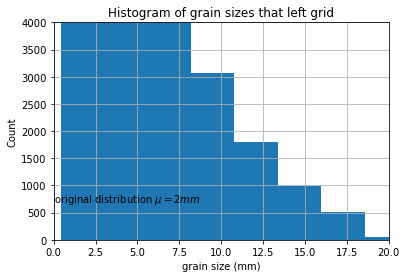

3801.58915081
3850


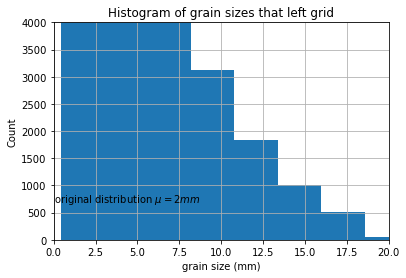

3851.01832524
3900


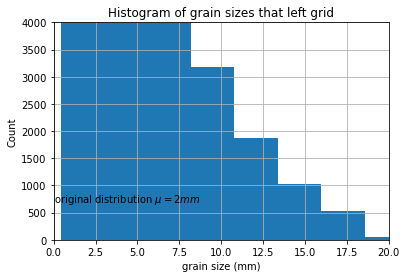

3900.79274637
3950


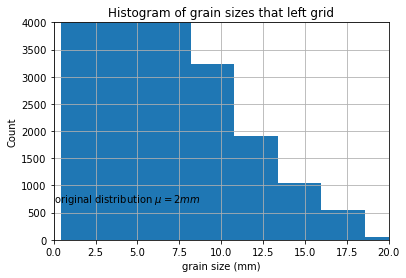

3951.10260482
4000


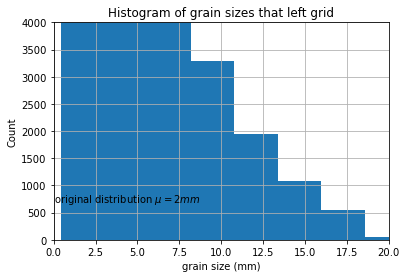

4000.96457925
4050


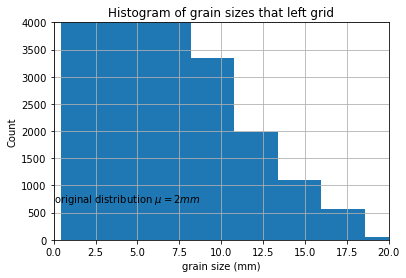

4051.40788184
4100


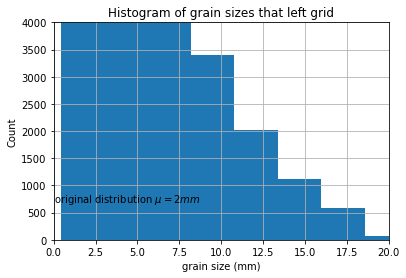

4101.47324707
4150


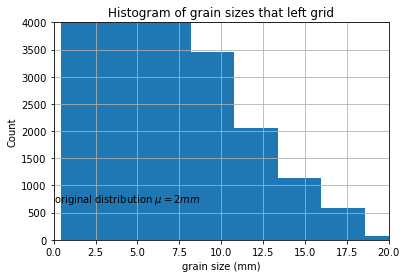

4151.8065897
4200


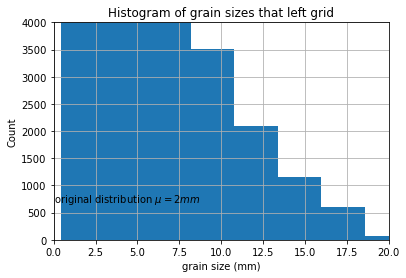

4201.88340697
4250


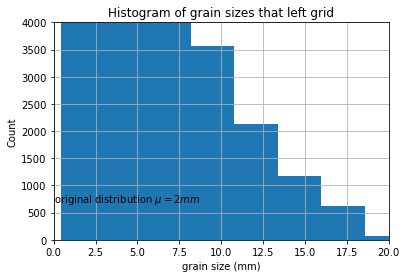

4251.96060865
4300


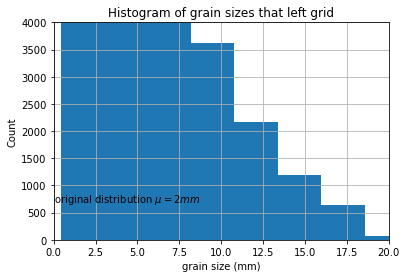

4301.95934784
4350


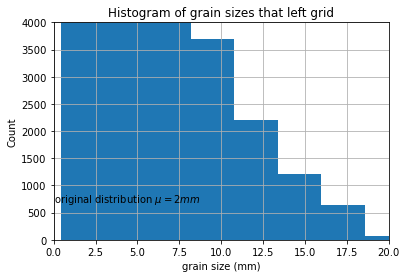

4351.69460754
4400


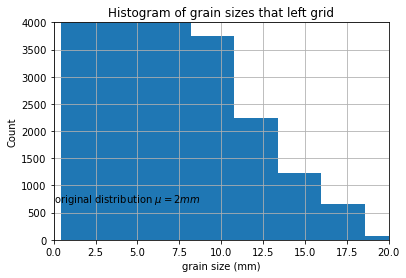

4401.25996665
4450


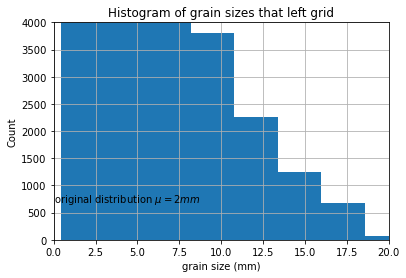

4451.30257616
4500


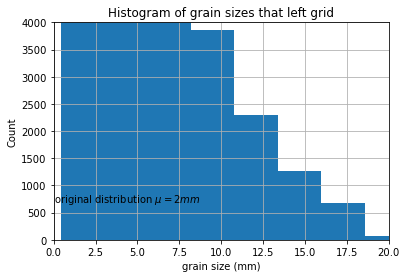

4501.44449526
4550


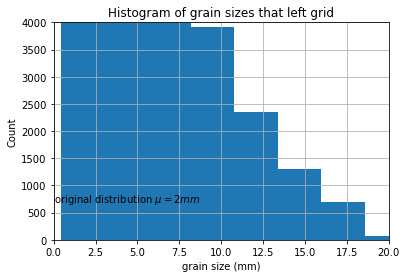

4551.80721933
4600


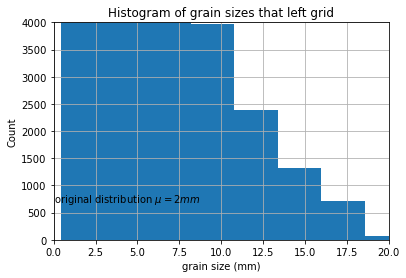

4601.8066494
4650


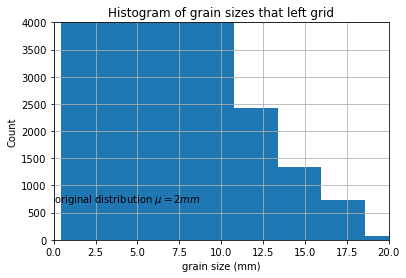

4651.80607947
4700


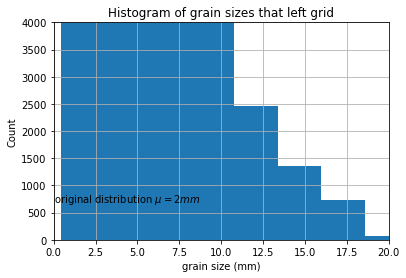

4701.80550954
4750


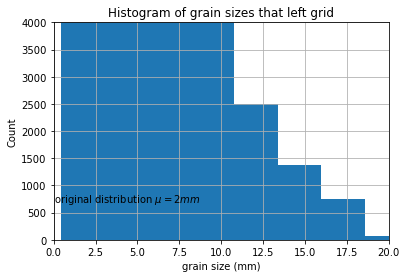

4751.80493961
4800


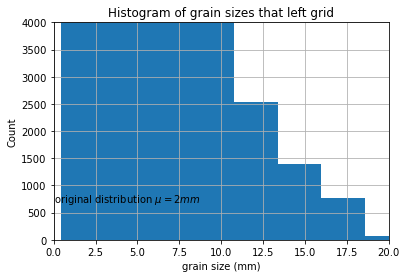

4801.80417153
4850


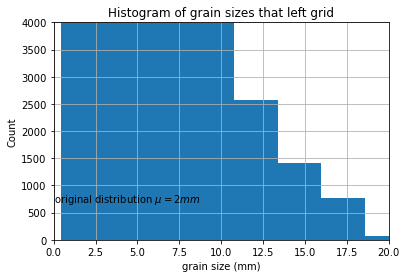

4851.80340345
4900


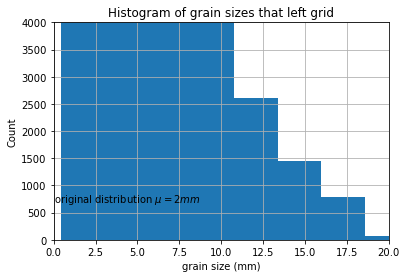

4901.80263537
4950


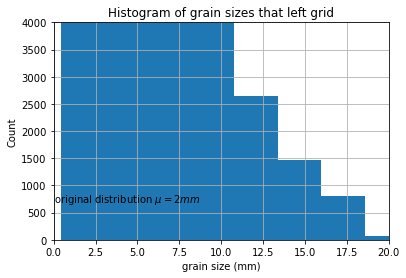

4951.80186729
5000


KeyboardInterrupt: 

In [27]:
# driving the model forward in a loop
elapsed_time = 1.
run_time = 5000
iters = 0
old_channel_depth = Channel_Depth
discharge_at_outlet = []
bools = (gridFP.node_x > nY/2 - Channel_Width*3) * (gridFP.node_x < nY/2 + Channel_Width*2) * (gridFP.node_y >= nX-5)

rainfall_id = 0

dt_sed = 50

run_time_slices = np.arange(50,run_time+1,dt_sed)

for t in run_time_slices:
    print(t)
    elapsed_time_FP = float(elapsed_time)
    
    while elapsed_time < t:
    
        # make rain

        if int(elapsed_time) in scaled_days_storms:
            # print("STORMMMM")
            # Update rainfall dataset id
            rainfall_id += 1
            rainfall_name = 'rainfall__flux_' + str(rainfall_id)
            # print(rainfall_id)

            # Avoid last time step
            if rainfall_id <= len(scaled_days_storms):
                # Read rainfall data
                # rmg.at_node.pop('rainfall__flux')
                read_esri_ascii('./rainfall_series/rainfall_' + str(rainfall_id) + '.asc', 
                                grid=rmg, name=rainfall_name)
                # Add rainfall event to water depth
                rmg.at_node['surface_water__depth'] += rmg.at_node[rainfall_name]    
        # route overland flow

        # First, we calculate our time step.
        dt_overland = .5#networkOF.calc_time_step()
        #print('overland flow timestep is',dt_overland,'seconds')
        # Now, we can generate overland flow.
        networkOF.overland_flow(dt_overland)
        # Increased elapsed time
        elapsed_time += dt_overland
        #print("Model time: ",elapsed_time/(60*60*24), "days passed")
        ## Append time and discharge and water depth to their lists to save data and for plotting.
        hydrograph_time.append(elapsed_time) 
        q_output = rmg.at_link["surface_water__discharge"]
        discharge_at_outlet.append(np.abs(q_output[outlet_link_to_sample]) * rmg.dx)
        h_output = rmg.at_node['surface_water__depth']
        height_at_outlet.append(np.max(h_output[search_box]))


    # route sediment

    # updated the water depth in network graph
    for i in range(new_network_grid.number_of_links):
        idx_node_1_link = new_network_grid.nodes_at_link[i][0]
        idx_nearest_raster_cell = rmg.find_nearest_node([
            new_network_grid.x_of_node[idx_node_1_link], 
            new_network_grid.y_of_node[idx_node_1_link]])
        nmg_link_h[i] = rmg.at_node['surface_water__depth'][idx_nearest_raster_cell] 
    new_network_grid.at_link["flow_depth"] = nmg_link_h.copy()
    
    nst.run_one_step(dt_sed)
    fv.plot_parcels(new_network_grid, parcels, elapsed_time, outlet_nearest_raster_cell, filepath = "./output/")
    #Plot overland flow 
    #fv.plot_overland_flow(rmg, cmap, outlet_nearest_raster_cell,elapsed_time)
    
    # change the floodplain
    
    new_channel_depth = Datum - new_network_grid.at_node['topographic__elevation'][14]
    
    zFP[isChannel] += new_channel_depth - old_channel_depth
    
    old_channel_depth = new_channel_depth
    fv.plot_overland_flow(rmg, mycmap, outlet_nearest_raster_cell,elapsed_time, filepath="./output/")


    k = 0
    
    while elapsed_time_FP < t:
        hFP[bools] = height_at_outlet[-1]
        if k %50 == 0:
            fv.plot_floodplain(gridFP, zFP, nX, nY, elapsed_time_FP, mycmap, filepath="./output/")
        # First, we calculate our time step.
        dt_overland = .5#floodplainOF.calc_time_step()
        #print('overland flow timestep is',dt_overland,'seconds')
        # Now, we can generate overland flow.
        floodplainOF.overland_flow(dt_overland)
        # now, allow water to infiltrate
        SI.run_one_step(dt_overland)
        # Increased elapsed time
        elapsed_time_FP += dt_overland
        
        k+=1   
     # route floodwater on floodplain
    
     # First, we calculate our time step.
    dt = networkOF.calc_time_step()
     # Now, we can generate overland flow.
    networkOF.overland_flow()
    SI.run_one_step(dt)
    #if elapsed_time %100==0:
    #Plot overland flow 
    elapsed_time += dt
    iters += 1
    print(elapsed_time)


Plotting Results Section

In [ ]:
#plot conditions at outlet node/ the info passed between grids
fv.plot_outlet_conditions(hydrograph_time, discharge_at_outlet, height_at_outlet, parcels)

Save Animations


In [ ]:
fv.save_animations("./output/")